**This will contain all the LSR incident analysis with the Ngen simulation outputs**

In [ ]:
#include necessary  libraries
import pandas as pd
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.linear_model import LinearRegression

In [2]:
lsr_path = Path("../data/FinalData/Filtered_LSR_withNexgenCatchmentsgt1.csv")
cfe_results_dir = Path("../data/FinalData/cfe_results")
nextgen_cat = Path("../data/FinalData/Nextgen_cat_subset.gpkg")

#Final PFI1 and PFI2 datasets
index_dir = Path("../data/FinalData/pluvial_final_run_alpha_corrected.csv")

In [3]:
def plot_damage_vs_giuhrunoff(csv_path):
    df = pd.read_csv(csv_path)
    valid = df[['runoff_volume', 'damage']].dropna()
    x_raw = valid['runoff_volume'].values.reshape(-1, 1)
    y = valid['damage'].values

    # Standardize GIUH runoff
    x_mean = x_raw.mean()
    x_std = x_raw.std()
    x_stdzd = (x_raw - x_mean) / x_std

    plt.figure(figsize=(6, 3))
    plt.scatter(x_raw, y, label='Data', color='blue')
    plt.xlabel('18-hour GIUH Runoff')
    plt.ylabel('Damage Percent')
    plt.title('Damage vs. Standardized GIUH Runoff')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

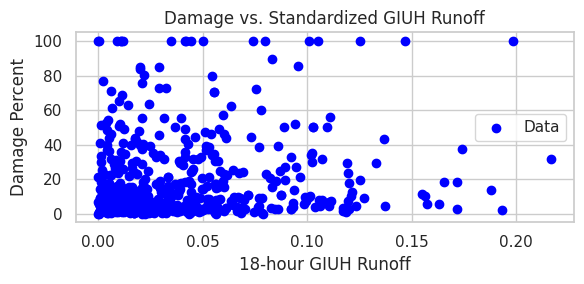

In [46]:
plot_damage_vs_giuhrunoff(index_dir)

**Understanding the cluster of the areas based on areas**

In [47]:
import seaborn as sns
index_dir  = Path("../data/FinalData/pluvial_final_run_alpha_corrected.csv")

/tmp/ipykernel_2547/1051564869.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataframe, x='area_bin', order=labels, palette='coolwarm', width = 0.8)


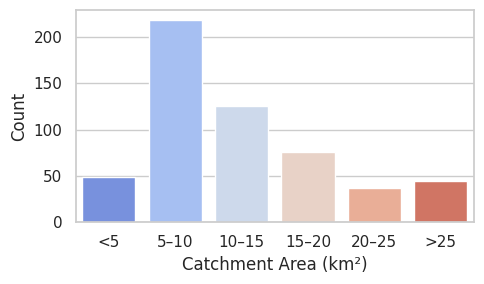

In [48]:
# Load data
dataframe = pd.read_csv(index_dir)
data_area = dataframe["area_sqkm"]

bins = [0, 5, 10, 15, 20, 25, float('inf')]
labels = ['<5', '5–10', '10–15', '15–20', '20–25', '>25']
dataframe['area_bin'] = pd.cut(data_area, bins=bins, labels=labels, right=False)

# Plot histogram by bin counts
plt.figure(figsize=(5, 3))
sns.countplot(data=dataframe, x='area_bin', order=labels, palette='coolwarm', width = 0.8)
plt.xlabel("Catchment Area (km²)")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# Load data
df = pd.read_csv(index_dir)

# Define area bins and labels
bins = [0, 5, 10, 15, float("inf")]
labels = ["0-5", "5-10", "10-15", ">15"]
df["area_range"] = pd.cut(df["area_sqkm"], bins=bins, labels=labels, right=False)

# Initialize new columns
df["PFI_1_scaled"] = np.nan
df["PFI_2_scaled"] = np.nan

# Standardize PFI_1 and PFI_2 within each area group
for label in labels:
    mask = df["area_range"] == label
    scaler = StandardScaler()
    if mask.sum() > 1: 
        df.loc[mask, "PFI_1_scaled"] = scaler.fit_transform(df.loc[mask, ["PFI_1"]])
        df.loc[mask, "PFI_2_scaled"] = scaler.fit_transform(df.loc[mask, ["PFI_2"]])
    else:
        # fallback for single row groups
        df.loc[mask, "PFI_1_scaled"] = 0
        df.loc[mask, "PFI_2_scaled"] = 0

# Normalize the entire scaled columns to [0, 1] range
scaler_norm = MinMaxScaler()
df["PFI_1_norm"] = scaler_norm.fit_transform(df[["PFI_1_scaled"]])
df["PFI_2_norm"] = scaler_norm.fit_transform(df[["PFI_2_scaled"]])

# Drop intermediate columns
df.drop(columns=["PFI_1_scaled", "PFI_2_scaled"], inplace=True)

# Save updated DataFrame
df.to_csv(index_dir, index=False)


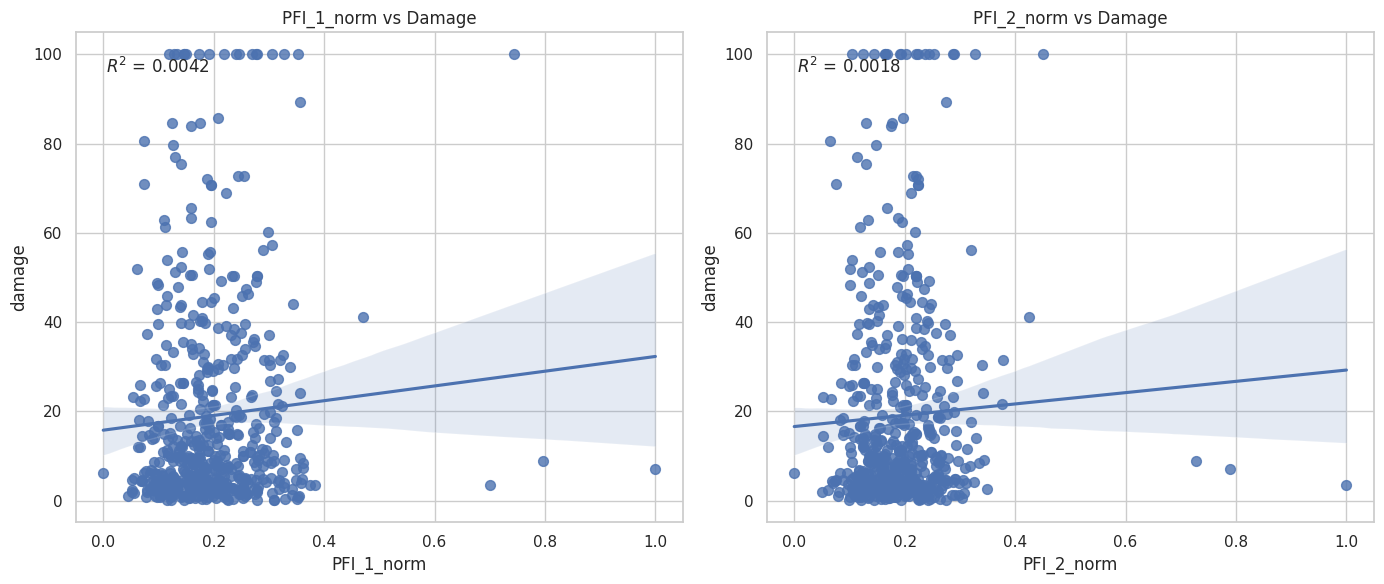

In [50]:
# Load your data
from sklearn.metrics import r2_score
df = pd.read_csv(index_dir) 

# Drop rows with missing values in relevant columns
df_clean = df.dropna(subset=["PFI_1_norm", "PFI_2_norm", "damage"])

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set(style="whitegrid")

# === Plot 1: PFI_1_norm vs damage ===
x1 = df_clean["PFI_1_norm"].values.reshape(-1, 1)
y1 = df_clean["damage"].values
model1 = LinearRegression().fit(x1, y1)
y1_pred = model1.predict(x1)
r2_1 = r2_score(y1, y1_pred)

sns.regplot(x="PFI_1_norm", y="damage", data=df_clean, ax=axes[0], scatter_kws={'s': 50})
axes[0].text(0.05, 0.95, f"$R^2$ = {r2_1:.4f}", transform=axes[0].transAxes, fontsize=12, verticalalignment='top')
axes[0].set_title("PFI_1_norm vs Damage")

# === Plot 2: PFI_2_norm vs damage ===
x2 = df_clean["PFI_2_norm"].values.reshape(-1, 1)
y2 = df_clean["damage"].values
model2 = LinearRegression().fit(x2, y2)
y2_pred = model2.predict(x2)
r2_2 = r2_score(y2, y2_pred)

sns.regplot(x="PFI_2_norm", y="damage", data=df_clean, ax=axes[1], scatter_kws={'s': 50})
axes[1].text(0.05, 0.95, f"$R^2$ = {r2_2:.4f}", transform=axes[1].transAxes, fontsize=12, verticalalignment='top')
axes[1].set_title("PFI_2_norm vs Damage")

plt.tight_layout()
plt.show()

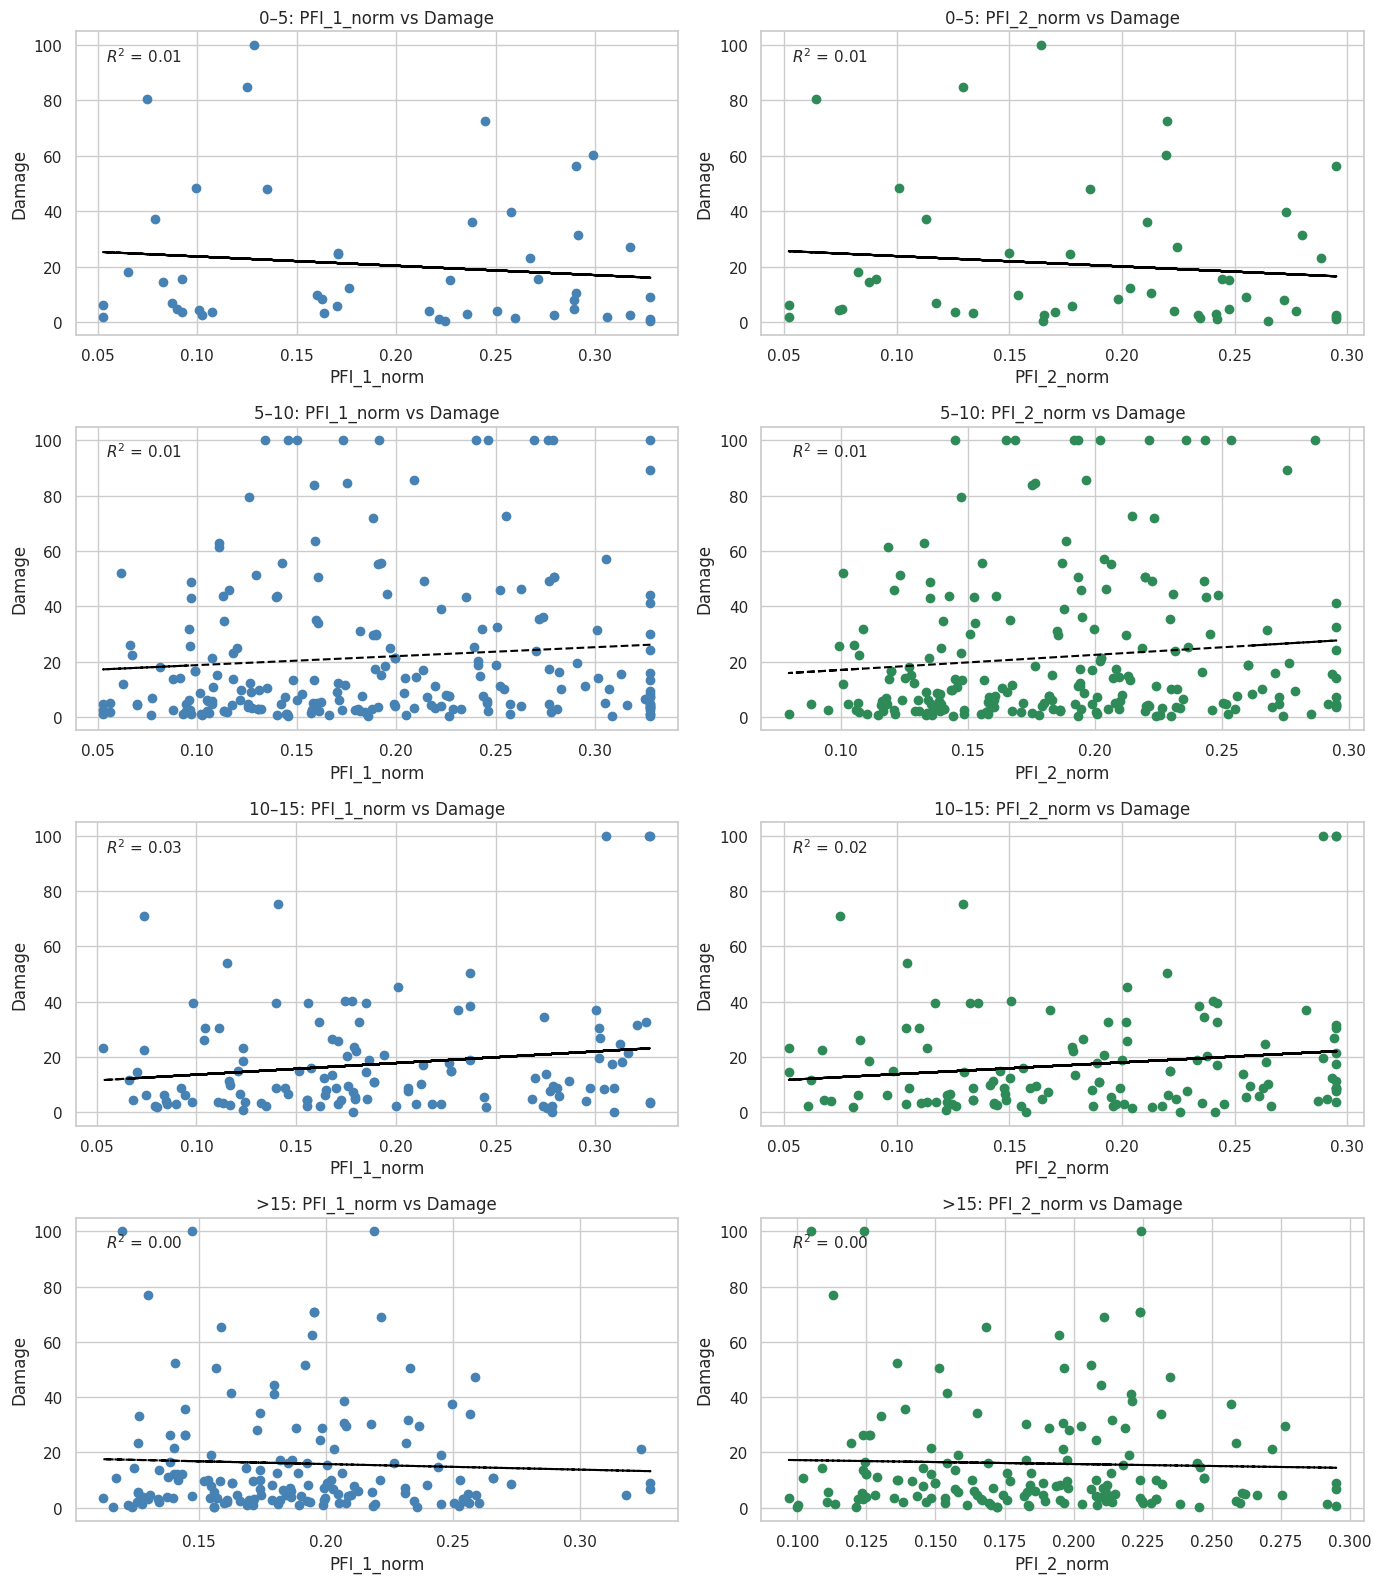

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Load the data
df = pd.read_csv(index_dir)  # Replace with your actual CSV path

# Drop missing values
df_clean = df.dropna(subset=["PFI_1_norm", "PFI_2_norm", "damage", "area_sqkm"])

# Clip PFI_1_norm and PFI_2_norm using 0.5th and 99.5th percentiles
pfi1_lower = np.percentile(df_clean["PFI_1_norm"], 0.5)
pfi1_upper = np.percentile(df_clean["PFI_1_norm"], 95)
df_clean["PFI_1_norm"] = df_clean["PFI_1_norm"].clip(lower=pfi1_lower, upper=pfi1_upper)

pfi2_lower = np.percentile(df_clean["PFI_2_norm"], 0.5)
pfi2_upper = np.percentile(df_clean["PFI_2_norm"], 95)
df_clean["PFI_2_norm"] = df_clean["PFI_2_norm"].clip(lower=pfi2_lower, upper=pfi2_upper)

# Define area groups
bins = [0, 5, 10, 15, float('inf')]
labels = ['0–5', '5–10', '10–15', '>15']
df_clean["area_group"] = pd.cut(df_clean["area_sqkm"], bins=bins, labels=labels)

# Set up 4x2 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
sns.set(style="whitegrid")
fig.subplots_adjust(hspace=0.4)

# Plot for each area group
for i, label in enumerate(labels):
    group = df_clean[df_clean["area_group"] == label]
    if len(group) < 2:
        continue

    # === PFI_1_norm vs Damage ===
    x1 = group["PFI_1_norm"].values.reshape(-1, 1)
    y1 = group["damage"].values
    model1 = LinearRegression().fit(x1, y1)
    y1_pred = model1.predict(x1)
    r2_1 = r2_score(y1, y1_pred)

    ax1 = axes[i, 0]
    ax1.scatter(x1, y1, color='steelblue')
    ax1.plot(x1, y1_pred, color='black', linestyle='--')
    ax1.set_title(f"{label}: PFI_1_norm vs Damage")
    ax1.set_xlabel("PFI_1_norm")
    ax1.set_ylabel("Damage")
    ax1.text(0.05, 0.95, f"$R^2$ = {r2_1:.2f}", transform=ax1.transAxes, fontsize=11, verticalalignment='top')

    # === PFI_2_norm vs Damage ===
    x2 = group["PFI_2_norm"].values.reshape(-1, 1)
    y2 = group["damage"].values
    model2 = LinearRegression().fit(x2, y2)
    y2_pred = model2.predict(x2)
    r2_2 = r2_score(y2, y2_pred)

    ax2 = axes[i, 1]
    ax2.scatter(x2, y2, color='seagreen')
    ax2.plot(x2, y2_pred, color='black', linestyle='--')
    ax2.set_title(f"{label}: PFI_2_norm vs Damage")
    ax2.set_xlabel("PFI_2_norm")
    ax2.set_ylabel("Damage")
    ax2.text(0.05, 0.95, f"$R^2$ = {r2_2:.2f}", transform=ax2.transAxes, fontsize=11, verticalalignment='top')

# Final layout
plt.tight_layout()
plt.show()


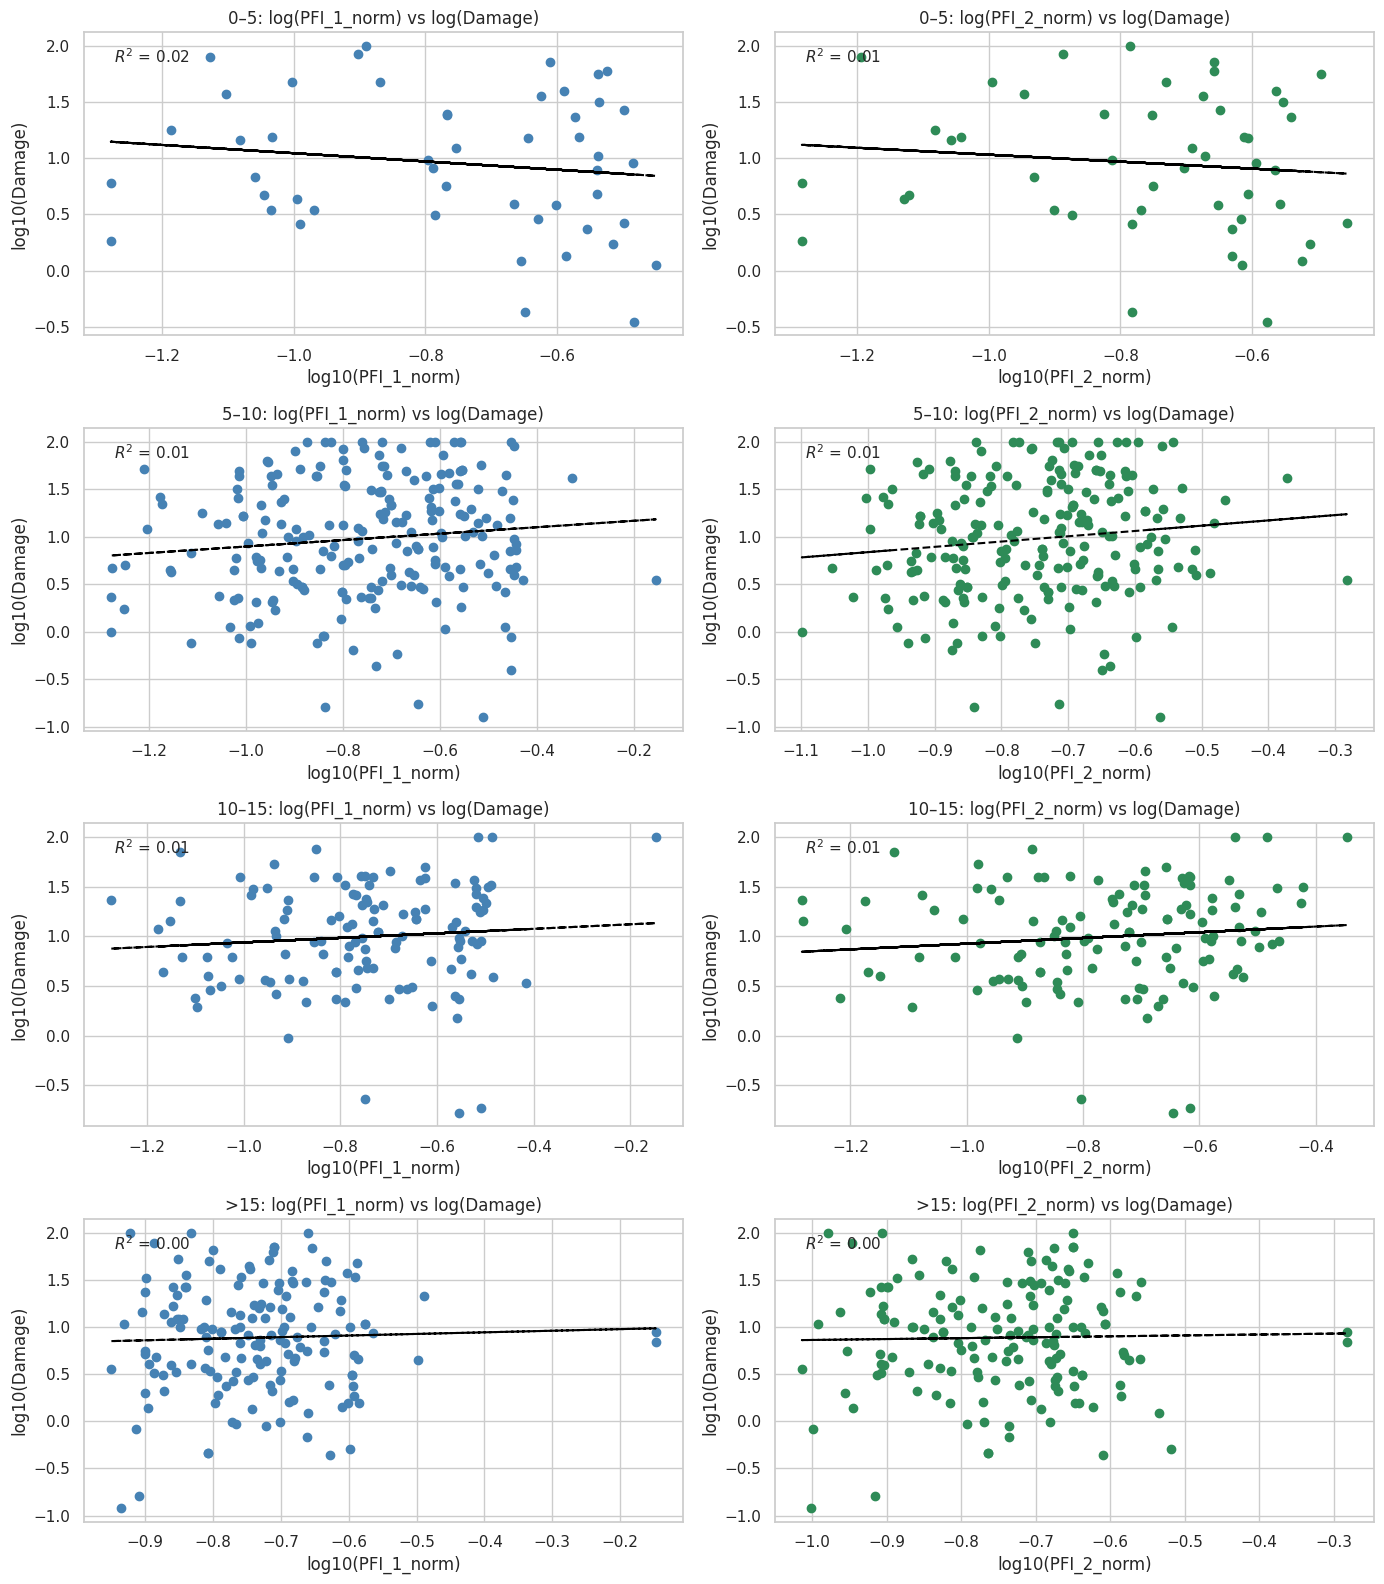

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Load the data
df = pd.read_csv(index_dir)  # Replace with your actual CSV path

# Drop missing values
df_clean = df.dropna(subset=["PFI_1_norm", "PFI_2_norm", "damage", "area_sqkm"])

# Clip extreme values (optional for stability)
pfi1_lower = np.percentile(df_clean["PFI_1_norm"], 0.5)
pfi1_upper = np.percentile(df_clean["PFI_1_norm"], 99.5)
df_clean["PFI_1_norm"] = df_clean["PFI_1_norm"].clip(lower=pfi1_lower, upper=pfi1_upper)

pfi2_lower = np.percentile(df_clean["PFI_2_norm"], 0.5)
pfi2_upper = np.percentile(df_clean["PFI_2_norm"], 99.5)
df_clean["PFI_2_norm"] = df_clean["PFI_2_norm"].clip(lower=pfi2_lower, upper=pfi2_upper)

# Define area groups
bins = [0, 5, 10, 15, float('inf')]
labels = ['0–5', '5–10', '10–15', '>15']
df_clean["area_group"] = pd.cut(df_clean["area_sqkm"], bins=bins, labels=labels)

# Log transformation (add epsilon to avoid log(0))
epsilon = 1e-8
df_clean["log_PFI_1_norm"] = np.log10(df_clean["PFI_1_norm"] + epsilon)
df_clean["log_PFI_2_norm"] = np.log10(df_clean["PFI_2_norm"] + epsilon)
df_clean["log_damage"] = np.log10(df_clean["damage"] + epsilon)

# Set up 4x2 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
sns.set(style="whitegrid")
fig.subplots_adjust(hspace=0.4)

# Plot for each area group
for i, label in enumerate(labels):
    group = df_clean[df_clean["area_group"] == label]
    if len(group) < 2:
        continue

    # === log(PFI_1_norm) vs log(Damage) ===
    x1 = group["log_PFI_1_norm"].values.reshape(-1, 1)
    y1 = group["log_damage"].values
    model1 = LinearRegression().fit(x1, y1)
    y1_pred = model1.predict(x1)
    r2_1 = r2_score(y1, y1_pred)

    ax1 = axes[i, 0]
    ax1.scatter(x1, y1, color='steelblue')
    ax1.plot(x1, y1_pred, color='black', linestyle='--')
    ax1.set_title(f"{label}: log(PFI_1_norm) vs log(Damage)")
    ax1.set_xlabel("log10(PFI_1_norm)")
    ax1.set_ylabel("log10(Damage)")
    ax1.text(0.05, 0.95, f"$R^2$ = {r2_1:.2f}", transform=ax1.transAxes, fontsize=11, verticalalignment='top')

    # === log(PFI_2_norm) vs log(Damage) ===
    x2 = group["log_PFI_2_norm"].values.reshape(-1, 1)
    y2 = group["log_damage"].values
    model2 = LinearRegression().fit(x2, y2)
    y2_pred = model2.predict(x2)
    r2_2 = r2_score(y2, y2_pred)

    ax2 = axes[i, 1]
    ax2.scatter(x2, y2, color='seagreen')
    ax2.plot(x2, y2_pred, color='black', linestyle='--')
    ax2.set_title(f"{label}: log(PFI_2_norm) vs log(Damage)")
    ax2.set_xlabel("log10(PFI_2_norm)")
    ax2.set_ylabel("log10(Damage)")
    ax2.text(0.05, 0.95, f"$R^2$ = {r2_2:.2f}", transform=ax2.transAxes, fontsize=11, verticalalignment='top')

# Final layout
plt.tight_layout()
plt.show()


In [ ]:
# Directories
main_csv_path = "../data/FinalData/pluvial_final_run_alpha_corrected.csv"
simulation_folder = "../data/FinalData/cfe_results"
output_csv_path = "../data/FinalData/non_pluvial_events_indices.csv"

# Load pluvial event data
main_df = pd.read_csv(main_csv_path, parse_dates=["starttime", "updated_event_date", "Event_date"])
main_df["catchment"] = main_df["catchment"].astype(str)

# Filter catchments with >3 events
valid_catchments = main_df["catchment"].value_counts()
valid_catchments = valid_catchments[valid_catchments > 3].index.tolist()
print(f"Valid catchments: {valid_catchments}")

# Store results
non_pluvial_records = []

# Loop over valid catchments
for cat_id in valid_catchments:
    sim_file = os.path.join(simulation_folder, f"{cat_id}.csv")
    if not os.path.exists(sim_file):
        print(f" Simulation file not found for: {cat_id}")
        continue

    sim_df = pd.read_csv(sim_file)

    # Identify time column
    date_col = next((col for col in sim_df.columns if col.strip().lower() == "time"), None)
    if not date_col:
        print(f"'Time' column not found in {sim_file}")
        continue

    sim_df = sim_df.rename(columns={date_col: "starttime"})
    sim_df["starttime"] = pd.to_datetime(sim_df["starttime"], errors="coerce")
    sim_df = sim_df.dropna(subset=["starttime"]).sort_values("starttime").copy()

    # Identify rain and runoff columns
    runoff_col = next((col for col in sim_df.columns if col.strip().upper() == "GIUH_RUNOFF"), None)
    rain_col = next((col for col in sim_df.columns if col.strip().upper() == "RAIN_RATE"), None)

    if not runoff_col or not rain_col:
        print(f"Missing GIUH_RUNOFF or RAIN_RATE in {sim_file}")
        continue

    known_times = main_df[main_df["catchment"] == cat_id]["starttime"]

    # Candidate non-pluvial times
    candidate_times = [
        t for t in sim_df["starttime"]
        if not any(abs(t - evt) < timedelta(days=4) for evt in known_times)
        and any(abs(t - evt) <= timedelta(days=8) for evt in known_times)
    ]

    if not candidate_times:
        print(f"No candidate times for {cat_id}")
        continue

    selected_times = random.sample(candidate_times, min(12, len(candidate_times)))

    for ref_time in selected_times:
        t_start = ref_time - timedelta(hours=18)
        t_end = ref_time

        window = sim_df[(sim_df["starttime"] >= t_start) & (sim_df["starttime"] <= t_end)]

        if window.empty:
            continue

        runoff_volume = window[runoff_col].sum()
        rain_volume = window[rain_col].sum()
        max_runoff = window[runoff_col].max()
        max_rain = window[rain_col].max()

        PFI_1 = runoff_volume / rain_volume if rain_volume > 0 else np.nan
        PFI_2 = max_runoff / max_rain if max_rain > 0 else np.nan

        static_row = main_df[main_df["catchment"] == cat_id].sample(n=1).iloc[0]

        non_pluvial_records.append({
            "Event_date": static_row["Event_date"],                    # Keep original pluvial event time
            "updated_event_date": static_row["updated_event_date"],    # Same as above
            "starttime": static_row["starttime"],                      # Same as above
            "reference_time": ref_time,                                # NEW: non-pluvial extraction point
            "catchment": cat_id,
            "area_sqkm": static_row.get("area_sqkm", np.nan),
            "runoff_volume": runoff_volume,
            "rainfall_volume": rain_volume,
            "PFI_1": PFI_1,
            "PFI_2": PFI_2,
            "rainrate": max_rain,
            "giuh_runoff": max_runoff,
            "event_type": "non_pluvial"
        })

non_pluvial_df = pd.DataFrame(non_pluvial_records)
non_pluvial_df.to_csv(output_csv_path, index=False)
print(f"Non-pluvial events saved to: {output_csv_path}")

✔️ Valid catchments: ['cat-1092307', 'cat-655183', 'cat-1324836', 'cat-1123000', 'cat-813937', 'cat-491544', 'cat-505611', 'cat-91769', 'cat-95082', 'cat-1123314']
✅ Non-pluvial events saved to: ../data/FinalData/non_pluvial_events_indices.csv


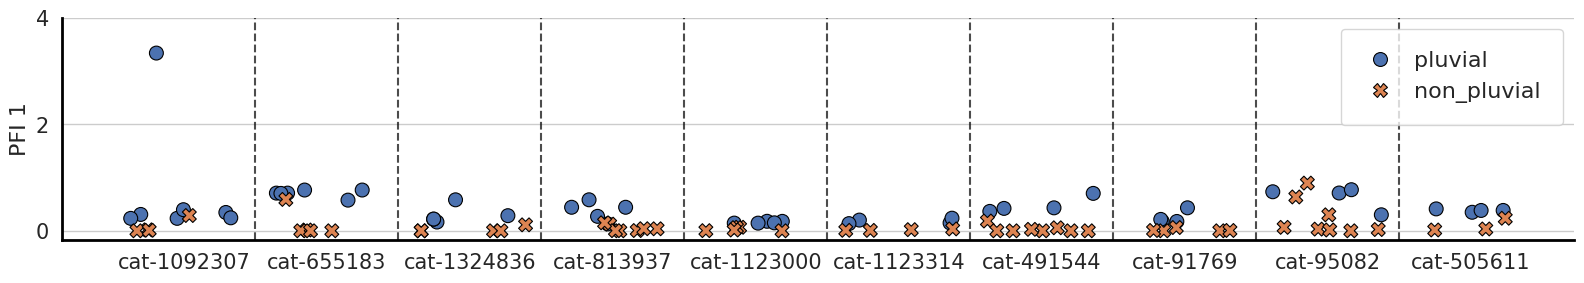

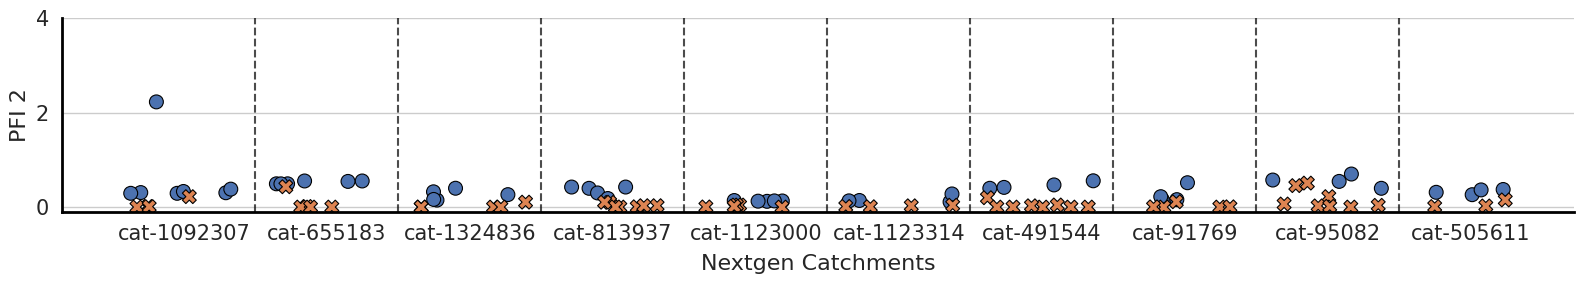

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load CSVs ===
pluvial_df = pd.read_csv("../data/FinalData/pluvial_final_run_alpha_corrected.csv")
nonpluvial_df = pd.read_csv("../data/FinalData/non_pluvial_events_indices.csv")

# === INPUTS ===
valid_catchments = [
    'cat-1092307', 'cat-655183', 'cat-1324836', 'cat-813937',
    'cat-1123000', 'cat-1123314', 'cat-491544', 'cat-91769',
    'cat-95082', 'cat-505611'
]

# Add event type
pluvial_df["event_type"] = "pluvial"
nonpluvial_df["event_type"] = "non_pluvial"

# Filter for valid catchments
pluvial_df = pluvial_df[pluvial_df["catchment"].isin(valid_catchments)]
nonpluvial_df = nonpluvial_df[nonpluvial_df["catchment"].isin(valid_catchments)]

# Combine datasets
combined_df = pd.concat([pluvial_df, nonpluvial_df], ignore_index=True)

# === Setup for Jittering and Field Widths ===
band_width = 1.0
padding = 0.2
catchment_to_center = {cat: 0.5 + i * band_width for i, cat in enumerate(valid_catchments)}
combined_df["band_center"] = combined_df["catchment"].map(catchment_to_center)

np.random.seed(42)
combined_df["jitter_x"] = combined_df["band_center"] + np.random.uniform(
    low=-0.5 * (band_width - padding),
    high=0.5 * (band_width - padding),
    size=len(combined_df)
)

# === Plot Function ===
def plot_pfi(metric, ylabel, show_xlabel=False, show_legend=False):
    plt.figure(figsize=(16, 3))
    sns.set(style="whitegrid")

    # Scatter plot
    ax = sns.scatterplot(
        data=combined_df,
        x="jitter_x",
        y=metric,
        hue="event_type",
        style="event_type",
        s=100,
        edgecolor='black'
    )

    # Vertical dividers
    for i in range(1, len(valid_catchments)):
        x = i * band_width
        ax.axvline(x=x, linestyle="--", color="black", linewidth=1.5, alpha=0.7)

    # Catchment labels
    for cat, center in catchment_to_center.items():
        ax.text(
            center,
            -0.06,
            cat,
            ha='center',
            va='top',
            fontsize=15,
            transform=ax.get_xaxis_transform()
        )

    # Bold black spines
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(2)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Format tick labels
    ax.set_xticks([])
    ax.set_yticks([0, 2, 4])  
    ax.tick_params(axis='y', labelsize=15)

    if show_xlabel:
        ax.set_xlabel("Nextgen Catchments", fontsize=16, labelpad=30)
    else:
        ax.set_xlabel("")

    ax.set_ylabel(ylabel, fontsize=16)

    if not show_legend:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
    else:
        plt.legend(
            title=None,
            fontsize=16,
            loc="best",
            handlelength=1.5,
            borderpad=1.0
        )

    plt.tight_layout()
    plt.savefig("../outputs/pluvial_nonPluvial_notnormalized.png", dpi = 500)
    plt.show()

# === Generate Plots ===
plot_pfi("PFI_1", "PFI 1", show_xlabel=False, show_legend=True)
plot_pfi("PFI_2", "PFI 2", show_xlabel=True, show_legend=False)


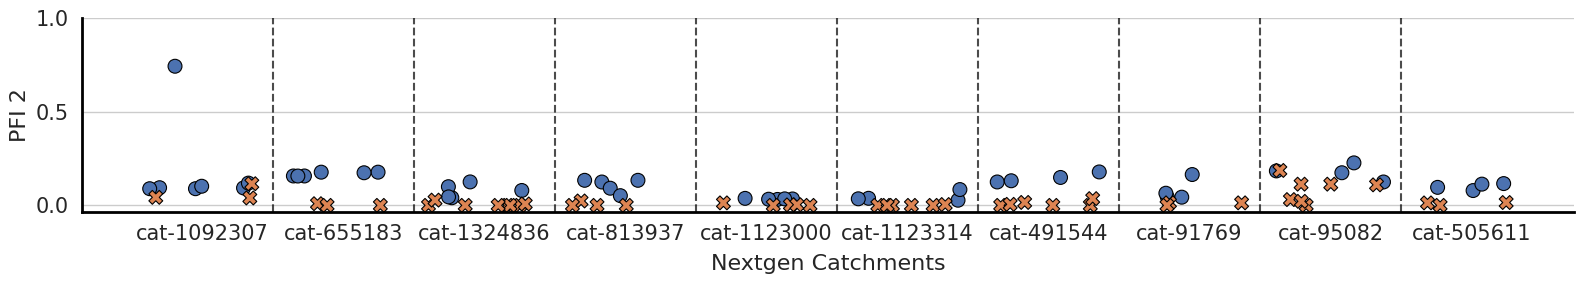

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load CSVs ===
pluvial_df = pd.read_csv("../data/FinalData/pluvial_final_run_alpha_corrected.csv")
nonpluvial_df = pd.read_csv("../data/FinalData/non_pluvial_events_indices.csv")

# === Standardization and Normalization (Separate for PFI_1 and PFI_2 using pluvial only) ===

# For PFI_1
mean_pfi1 = pluvial_df["PFI_1"].mean()
std_pfi1 = pluvial_df["PFI_1"].std()

pluvial_df["PFI_1_std"] = (pluvial_df["PFI_1"] - mean_pfi1) / std_pfi1
nonpluvial_df["PFI_1_std"] = (nonpluvial_df["PFI_1"] - mean_pfi1) / std_pfi1

min_pfi1 = pluvial_df["PFI_1_std"].min()
max_pfi1 = pluvial_df["PFI_1_std"].max()

pluvial_df["PFI_1_norm"] = (pluvial_df["PFI_1_std"] - min_pfi1) / (max_pfi1 - min_pfi1)
nonpluvial_df["PFI_1_norm"] = (nonpluvial_df["PFI_1_std"] - min_pfi1) / (max_pfi1 - min_pfi1)

# For PFI_2
mean_pfi2 = pluvial_df["PFI_2"].mean()
std_pfi2 = pluvial_df["PFI_2"].std()

pluvial_df["PFI_2_std"] = (pluvial_df["PFI_2"] - mean_pfi2) / std_pfi2
nonpluvial_df["PFI_2_std"] = (nonpluvial_df["PFI_2"] - mean_pfi2) / std_pfi2

min_pfi2 = pluvial_df["PFI_2_std"].min()
max_pfi2 = pluvial_df["PFI_2_std"].max()

pluvial_df["PFI_2_norm"] = (pluvial_df["PFI_2_std"] - min_pfi2) / (max_pfi2 - min_pfi2)
nonpluvial_df["PFI_2_norm"] = (nonpluvial_df["PFI_2_std"] - min_pfi2) / (max_pfi2 - min_pfi2)

# === Define valid catchments ===
valid_catchments = [
    'cat-1092307', 'cat-655183', 'cat-1324836', 'cat-813937',
    'cat-1123000', 'cat-1123314', 'cat-491544', 'cat-91769',
    'cat-95082', 'cat-505611'
]

# Add event type
pluvial_df["event_type"] = "pluvial"
nonpluvial_df["event_type"] = "non_pluvial"

# Filter for valid catchments
pluvial_df = pluvial_df[pluvial_df["catchment"].isin(valid_catchments)]
nonpluvial_df = nonpluvial_df[nonpluvial_df["catchment"].isin(valid_catchments)]

# Combine datasets
combined_df = pd.concat([pluvial_df, nonpluvial_df], ignore_index=True)

# === Clip values to [0, 1] range ===
combined_df["PFI_1_norm"] = combined_df["PFI_1_norm"].clip(0, 1)
combined_df["PFI_2_norm"] = combined_df["PFI_2_norm"].clip(0, 1)

# === Setup for Jittering and Catchment Band Widths ===
band_width = 1.0
padding = 0.2
catchment_to_center = {cat: 0.5 + i * band_width for i, cat in enumerate(valid_catchments)}
combined_df["band_center"] = combined_df["catchment"].map(catchment_to_center)

np.random.seed(42)
combined_df["jitter_x"] = combined_df["band_center"] + np.random.uniform(
    low=-0.5 * (band_width - padding),
    high=0.5 * (band_width - padding),
    size=len(combined_df)
)

# === Plotting Function ===
def plot_pfi(metric, ylabel, show_xlabel=False, show_legend=False):
    plt.figure(figsize=(16, 3))
    sns.set(style="whitegrid")

    ax = sns.scatterplot(
        data=combined_df,
        x="jitter_x",
        y=metric,
        hue="event_type",
        style="event_type",
        s=100,
        edgecolor='black'
    )

    # Vertical dividers between catchments
    for i in range(1, len(valid_catchments)):
        x = i * band_width
        ax.axvline(x=x, linestyle="--", color="black", linewidth=1.5, alpha=0.7)

    # Catchment labels
    for cat, center in catchment_to_center.items():
        ax.text(
            center,
            -0.06,
            cat,
            ha='center',
            va='top',
            fontsize=15,
            transform=ax.get_xaxis_transform()
        )

    # Bold axis lines
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(2)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([0, 0.5, 1]) 
    ax.tick_params(axis='y', labelsize=15)

    if show_xlabel:
        ax.set_xlabel("Nextgen Catchments", fontsize=16, labelpad=30)
    else:
        ax.set_xlabel("")

    ax.set_ylabel(ylabel, fontsize=16)

    if not show_legend:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
    else:
        plt.legend(
            title=None,
            fontsize=16,
            loc="best",
            handlelength=1.5,
            borderpad=1.0
        )

    plt.tight_layout()
    plt.savefig("../outputs/pluvial_nonPluvial_normalized_PFI2.png", dpi = 500)
    plt.show()

# === Generate Final Plots ===
# plot_pfi("PFI_1_norm", "PFI 1", show_xlabel=False, show_legend=True)
plot_pfi("PFI_2_norm", "PFI 2", show_xlabel=True, show_legend=False)


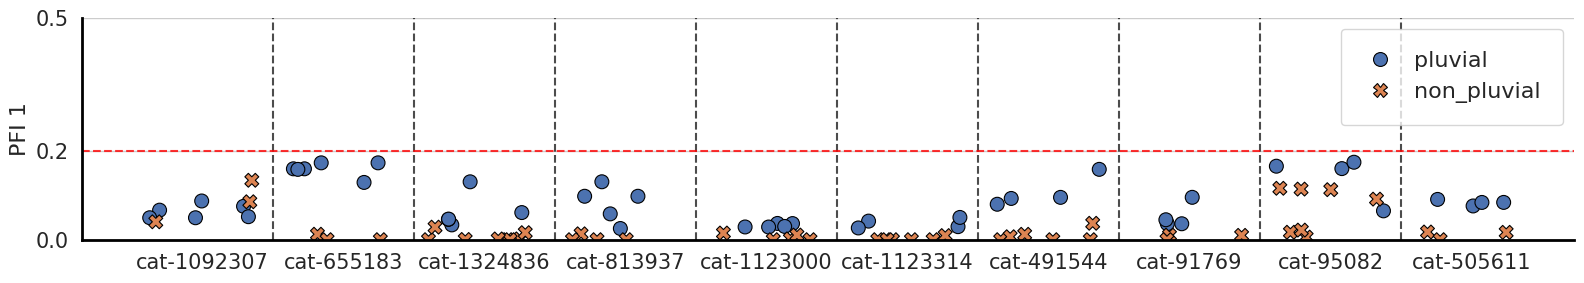

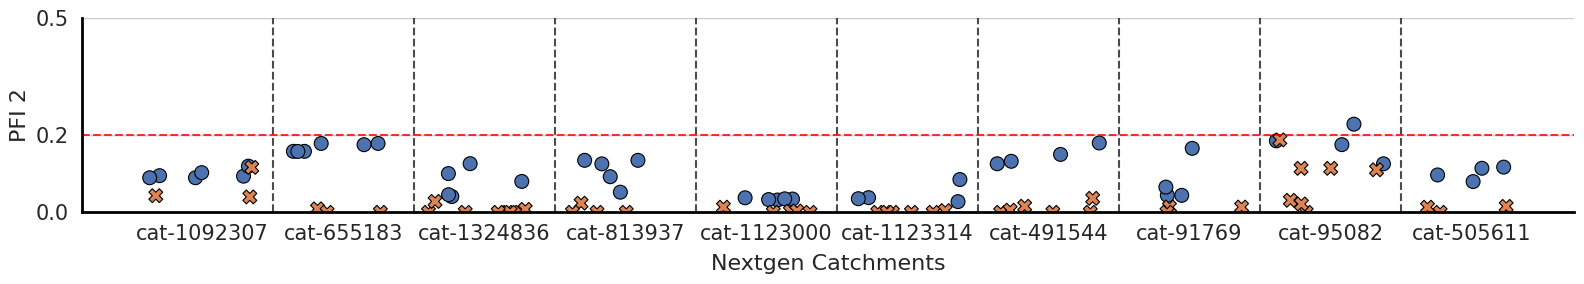

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load CSVs ===
pluvial_df = pd.read_csv("../data/FinalData/pluvial_final_run_alpha_corrected.csv")
nonpluvial_df = pd.read_csv("../data/FinalData/non_pluvial_events_indices.csv")

# === Standardization and Normalization (Separate for PFI_1 and PFI_2 using pluvial only) ===

# For PFI_1
mean_pfi1 = pluvial_df["PFI_1"].mean()
std_pfi1 = pluvial_df["PFI_1"].std()

pluvial_df["PFI_1_std"] = (pluvial_df["PFI_1"] - mean_pfi1) / std_pfi1
nonpluvial_df["PFI_1_std"] = (nonpluvial_df["PFI_1"] - mean_pfi1) / std_pfi1

min_pfi1 = pluvial_df["PFI_1_std"].min()
max_pfi1 = pluvial_df["PFI_1_std"].max()

pluvial_df["PFI_1_norm"] = (pluvial_df["PFI_1_std"] - min_pfi1) / (max_pfi1 - min_pfi1)
nonpluvial_df["PFI_1_norm"] = (nonpluvial_df["PFI_1_std"] - min_pfi1) / (max_pfi1 - min_pfi1)

# For PFI_2
mean_pfi2 = pluvial_df["PFI_2"].mean()
std_pfi2 = pluvial_df["PFI_2"].std()

pluvial_df["PFI_2_std"] = (pluvial_df["PFI_2"] - mean_pfi2) / std_pfi2
nonpluvial_df["PFI_2_std"] = (nonpluvial_df["PFI_2"] - mean_pfi2) / std_pfi2

min_pfi2 = pluvial_df["PFI_2_std"].min()
max_pfi2 = pluvial_df["PFI_2_std"].max()

pluvial_df["PFI_2_norm"] = (pluvial_df["PFI_2_std"] - min_pfi2) / (max_pfi2 - min_pfi2)
nonpluvial_df["PFI_2_norm"] = (nonpluvial_df["PFI_2_std"] - min_pfi2) / (max_pfi2 - min_pfi2)

# === Define valid catchments ===
valid_catchments = [
    'cat-1092307', 'cat-655183', 'cat-1324836', 'cat-813937',
    'cat-1123000', 'cat-1123314', 'cat-491544', 'cat-91769',
    'cat-95082', 'cat-505611'
]

# Add event type
pluvial_df["event_type"] = "pluvial"
nonpluvial_df["event_type"] = "non_pluvial"

# Filter for valid catchments
pluvial_df = pluvial_df[pluvial_df["catchment"].isin(valid_catchments)]
nonpluvial_df = nonpluvial_df[nonpluvial_df["catchment"].isin(valid_catchments)]

# Combine datasets
combined_df = pd.concat([pluvial_df, nonpluvial_df], ignore_index=True)

# === Clip values to [0, 1] range ===
combined_df["PFI_1_norm"] = combined_df["PFI_1_norm"].clip(0, 1)
combined_df["PFI_2_norm"] = combined_df["PFI_2_norm"].clip(0, 1)

# === Setup for Jittering and Catchment Band Widths ===
band_width = 1.0
padding = 0.2
catchment_to_center = {cat: 0.5 + i * band_width for i, cat in enumerate(valid_catchments)}
combined_df["band_center"] = combined_df["catchment"].map(catchment_to_center)

np.random.seed(42)
combined_df["jitter_x"] = combined_df["band_center"] + np.random.uniform(
    low=-0.5 * (band_width - padding),
    high=0.5 * (band_width - padding),
    size=len(combined_df)
)

# === Plotting Function ===
def plot_pfi(metric, ylabel, show_xlabel=False, show_legend=False):
    plt.figure(figsize=(16, 3))
    sns.set(style="whitegrid")

    ax = sns.scatterplot(
        data=combined_df,
        x="jitter_x",
        y=metric,
        hue="event_type",
        style="event_type",
        s=100,
        edgecolor='black'
    )

    # Vertical dividers between catchments
    for i in range(1, len(valid_catchments)):
        x = i * band_width
        ax.axvline(x=x, linestyle="--", color="black", linewidth=1.5, alpha=0.7)

    # Catchment labels
    for cat, center in catchment_to_center.items():
        ax.text(
            center,
            -0.06,
            cat,
            ha='center',
            va='top',
            fontsize=15,
            transform=ax.get_xaxis_transform()
        )

    # Horizontal reference line at y = 0.2
    ax.axhline(y=0.2, linestyle='--', color='red', linewidth=1.5, alpha=0.8)  # ← Add this

    # Bold axis lines
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(2)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([0, 0.2, 0.5])
    ax.set_ylim(0, 0.5)  # ← Restrict y-axis range here
    ax.tick_params(axis='y', labelsize=15)

    if show_xlabel:
        ax.set_xlabel("Nextgen Catchments", fontsize=16, labelpad=30)
    else:
        ax.set_xlabel("")

    ax.set_ylabel(ylabel, fontsize=16)

    if not show_legend:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
    else:
        plt.legend(
            title=None,
            fontsize=16,
            loc="best",
            handlelength=1.5,
            borderpad=1.0
        )

    plt.tight_layout()
    plt.show()

# === Generate Final Plots ===
plot_pfi("PFI_1_norm", "PFI 1", show_xlabel=False, show_legend=True)
plot_pfi("PFI_2_norm", "PFI 2", show_xlabel=True, show_legend=False)


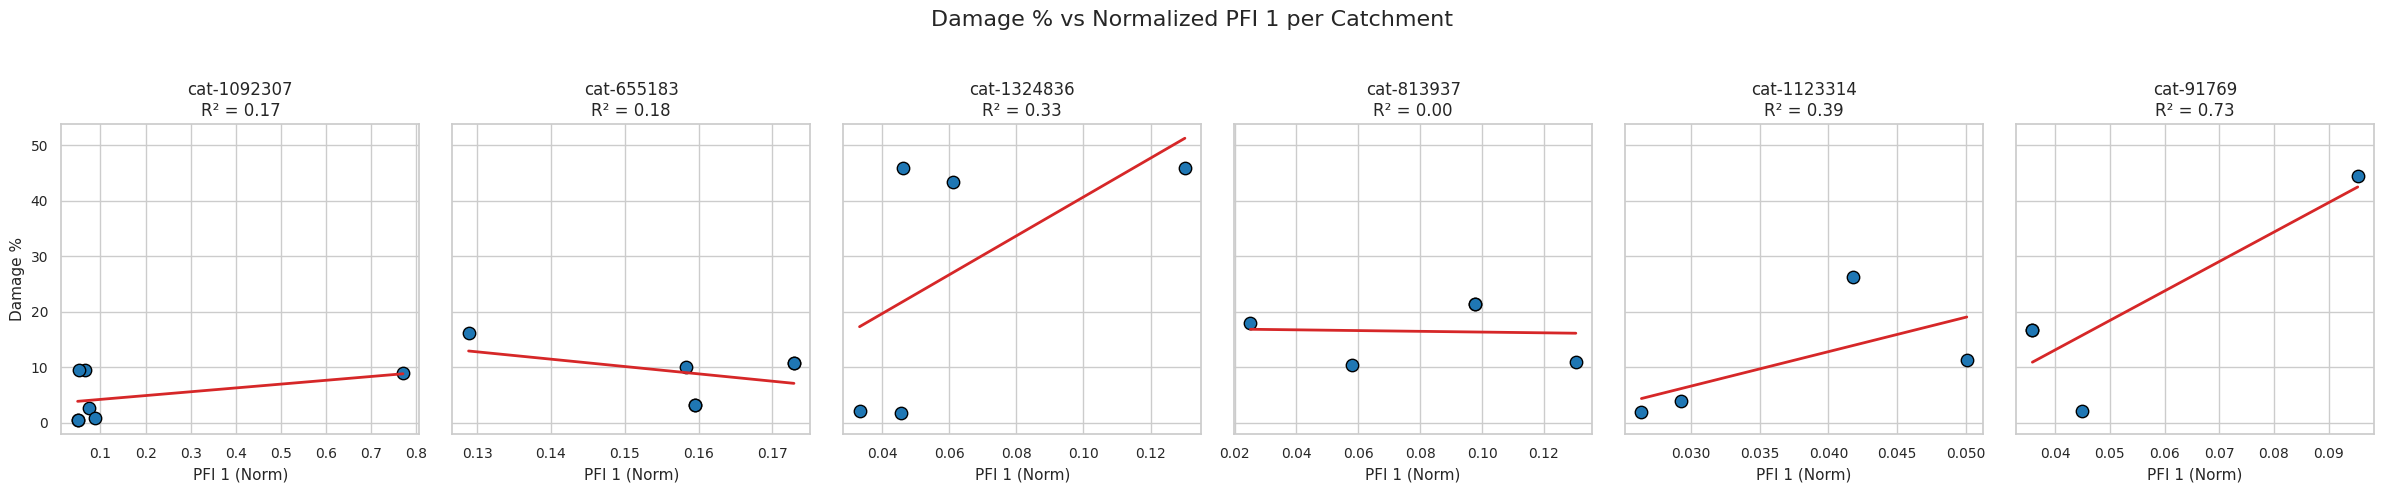

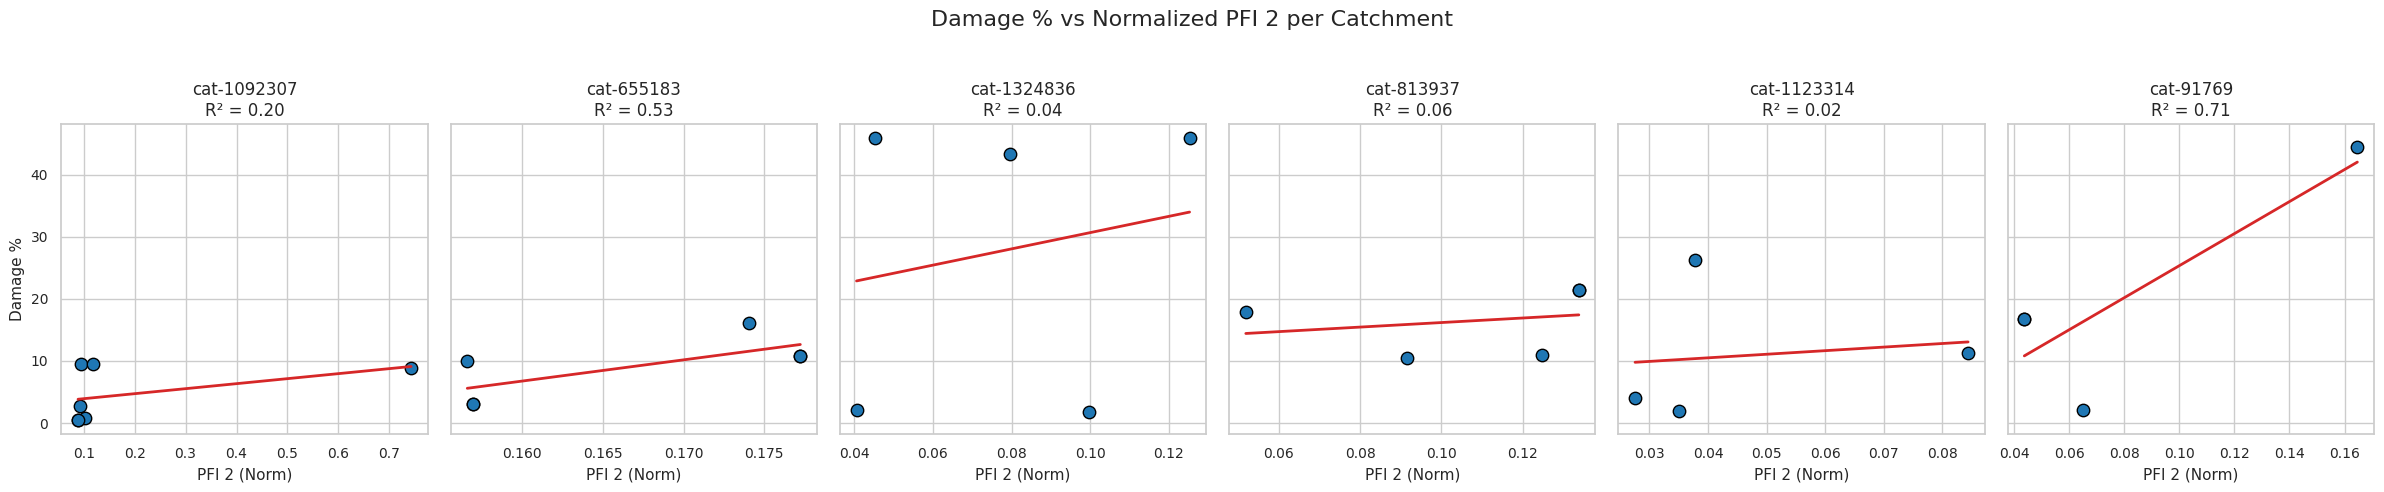

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# === Load Full Pluvial CSV ===
pluvial_df_full = pd.read_csv("../data/FinalData/pluvial_final_run_alpha_corrected.csv")

# === Standardize and Normalize PFI_1 ===
mean_pfi1 = pluvial_df_full["PFI_1"].mean()
std_pfi1 = pluvial_df_full["PFI_1"].std()
pluvial_df_full["PFI_1_std"] = (pluvial_df_full["PFI_1"] - mean_pfi1) / std_pfi1
min_pfi1 = pluvial_df_full["PFI_1_std"].min()
max_pfi1 = pluvial_df_full["PFI_1_std"].max()
pluvial_df_full["PFI_1_norm"] = (pluvial_df_full["PFI_1_std"] - min_pfi1) / (max_pfi1 - min_pfi1)

# === Standardize and Normalize PFI_2 ===
mean_pfi2 = pluvial_df_full["PFI_2"].mean()
std_pfi2 = pluvial_df_full["PFI_2"].std()
pluvial_df_full["PFI_2_std"] = (pluvial_df_full["PFI_2"] - mean_pfi2) / std_pfi2
min_pfi2 = pluvial_df_full["PFI_2_std"].min()
max_pfi2 = pluvial_df_full["PFI_2_std"].max()
pluvial_df_full["PFI_2_norm"] = (pluvial_df_full["PFI_2_std"] - min_pfi2) / (max_pfi2 - min_pfi2)

# === Valid Catchments ===
valid_catchments = [
    'cat-1092307', 'cat-655183', 'cat-1324836', 'cat-813937', 'cat-1123314', 'cat-91769'
]
pluvial_df = pluvial_df_full[pluvial_df_full["catchment"].isin(valid_catchments)]

# === Subplot Function ===
def subplot_damage_vs_pfi(df, metric, ylabel, title, output_file):
    sns.set(style="whitegrid")
    n = len(valid_catchments)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 5), sharey=True)

    for i, cat in enumerate(valid_catchments):
        ax = axes[i]
        subdf = df[df["catchment"] == cat]
        x = subdf[metric].values.reshape(-1, 1)
        y = subdf["damage"].values

        ax.scatter(x, y, color='tab:blue', edgecolor='black', s=80)

        if len(x) > 1:
            model = LinearRegression().fit(x, y)
            y_pred = model.predict(x)
            r2 = r2_score(y, y_pred)

            # Regression line
            x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            ax.plot(x_range, model.predict(x_range), color='tab:red', linewidth=2)

            ax.set_title(f"{cat}\nR² = {r2:.2f}", fontsize=12)
        else:
            ax.set_title(f"{cat}\nInsufficient data", fontsize=12)

        ax.set_xlabel(ylabel, fontsize=11)
        if i == 0:
            ax.set_ylabel("Damage %", fontsize=11)
        ax.tick_params(axis='both', labelsize=10)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, dpi=500)
    plt.show()

# === Generate Subplot Rows ===
subplot_damage_vs_pfi(
    pluvial_df,
    metric="PFI_1_norm",
    ylabel="PFI 1 (Norm)",
    title="Damage % vs Normalized PFI 1 per Catchment",
    output_file="../outputs/subplot_damage_vs_PFI_1_norm.png"
)

subplot_damage_vs_pfi(
    pluvial_df,
    metric="PFI_2_norm",
    ylabel="PFI 2 (Norm)",
    title="Damage % vs Normalized PFI 2 per Catchment",
    output_file="../outputs/subplot_damage_vs_PFI_2_norm.png"
)


**Get the accumulated and maximum forcings**

In [7]:
rainfall_dir = Path("../data/FinalData/pluvial_final_run_alpha_corrected_with_rainfall.csv")

In [8]:
import xarray as xr
import pandas as pd
import numpy as np
import os

# === Set input paths ===
parent_dir = "../ngiab_preprocess_output"
index_dir = "../data/FinalData/pluvial_final_run_alpha_corrected.csv"

# === Load CSV ===
df = pd.read_csv(index_dir, parse_dates=["starttime"])
df["catchment"] = df["catchment"].astype(str)

def get_18hr_rainfall_only(catchment_id, event_time):
    clean_id = catchment_id.replace("cat-", "") if catchment_id.startswith("cat-") else catchment_id
    forcing_path = os.path.join(parent_dir, f"cat-{clean_id}", "forcings", "forcings.nc")

    if not os.path.exists(forcing_path):
        print(f"Forcing file not found for catchment {catchment_id}")
        return np.nan, np.nan

    try:
        ds = xr.open_dataset(forcing_path)

        # Assign time coordinate safely
        if "Time" in ds:
            time_vals = pd.to_datetime(ds["Time"].isel({"catchment-id": 0}).values, unit="s", origin="unix")
            ds = ds.assign_coords(time=("time", time_vals))
        elif "time" in ds:
            ds["time"] = pd.to_datetime(ds["time"].values)
        else:
            return np.nan, np.nan

        # Define 18-hour window
        start = pd.to_datetime(event_time)
        end = start + pd.Timedelta(hours=18)
        time_mask = (ds.time >= start) & (ds.time < end)

        if time_mask.sum().item() == 0:
            return 0.0, 0.0

        # Precipitation values [mm/s] → [mm/hr]
        precip_vals = ds["precip_rate"].sel(time=time_mask).values * 3600
        return float(np.sum(precip_vals)), float(np.max(precip_vals))

    except Exception as e:
        print(f"Error reading {forcing_path}: {e}")
        return np.nan, np.nan

# Apply rainfall-only function
df[["rainfall_18hr_sum_mm", "rainfall_18hr_max_mmhr"]] = df.apply(
    lambda row: get_18hr_rainfall_only(row["catchment"], row["starttime"]),
    axis=1,
    result_type="expand"
)

#Saving result
df.to_csv(rainfall_dir, index=False)

**Get the accumulated and maximum Q out in this 18-hour interval**

In [9]:
import os
qout_dir = Path("../data/FinalData/pluvial_final_run_alpha_corrected_with_rainfall_qout.csv")

In [10]:
df = pd.read_csv(rainfall_dir, parse_dates=['starttime'])

# Function to extract 18hr Q_OUT from matching catchment CSV
def get_qout_18hr(catchment_id, event_time):
    csv_path = os.path.join(cfe_results_dir, f"{catchment_id}.csv")
    
    if not os.path.exists(csv_path):
        print(f"CSV not found for {catchment_id}")
        return pd.NA, pd.NA

    try:
        catchment_df = pd.read_csv(csv_path, parse_dates=['Time'])
    except Exception as e:
        print(f"Error reading {csv_path}: {e}")
        return pd.NA, pd.NA

    # Filter for 18 hours window
    start = pd.to_datetime(event_time)
    end = start + pd.Timedelta(hours=18)
    mask = (catchment_df['Time'] >= start) & (catchment_df['Time'] < end)
    window_df = catchment_df.loc[mask]

    if window_df.empty or 'Q_OUT' not in window_df.columns:
        return pd.NA, pd.NA

    qout_sum = window_df['Q_OUT'].sum()
    qout_max = window_df['Q_OUT'].max()
    return qout_sum, qout_max

In [11]:
df[['qout_18hr_sum', 'qout_18hr_max']] = df.apply(
    lambda row: get_qout_18hr(row['catchment'], row['starttime']),
    axis=1,
    result_type='expand'
)
df.to_csv(qout_dir, index=False)

**Analysis with rainfall and Q_out**

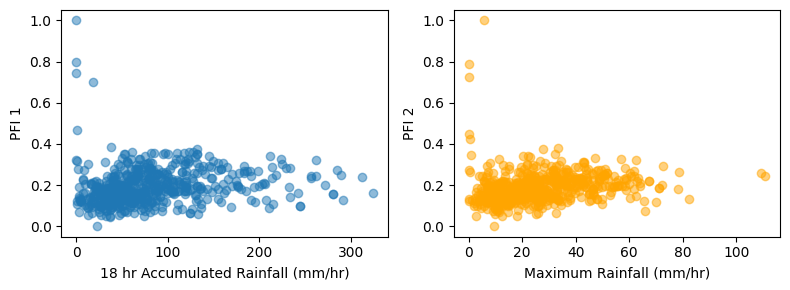

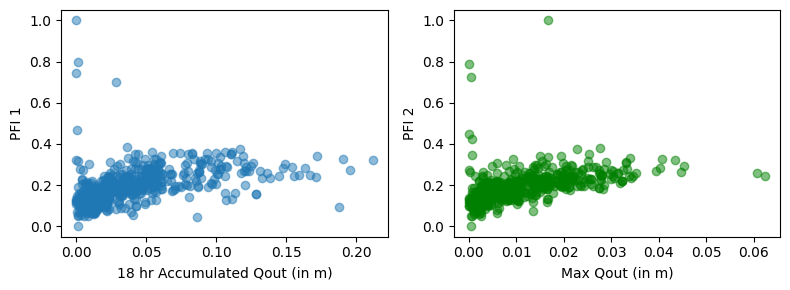

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv(qout_dir, parse_dates=["Event_date", "updated_event_date", "starttime"])

# Convert to numeric
cols_to_convert = [
    'PFI_1_norm', 'PFI_2_norm', 
    'rainfall_18hr_sum_mm', 'rainfall_18hr_max_mmhr', 
    'qout_18hr_sum', 'qout_18hr_max'
]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Figure 1 – Rainfall vs PFI
fig1, axes1 = plt.subplots(1, 2, figsize=(8, 3))

axes1[0].scatter(df['rainfall_18hr_sum_mm'], df['PFI_1_norm'], alpha=0.5)
axes1[0].set_xlabel('18 hr Accumulated Rainfall (mm/hr)')
axes1[0].set_ylabel('PFI 1')

axes1[1].scatter(df['rainfall_18hr_max_mmhr'], df['PFI_2_norm'], alpha=0.5, color='orange')
axes1[1].set_xlabel('Maximum Rainfall (mm/hr)')
axes1[1].set_ylabel('PFI 2')

plt.tight_layout()
plt.savefig("../outputs/rainfallvsindices.png", dpi=500)
plt.show()

# Figure 2 – Qout vs PFI
fig2, axes2 = plt.subplots(1, 2, figsize=(8, 3))

axes2[0].scatter(df['qout_18hr_sum'], df['PFI_1_norm'], alpha=0.5)
axes2[0].set_xlabel('18 hr Accumulated Qout (in m)')
axes2[0].set_ylabel('PFI 1')

axes2[1].scatter(df['qout_18hr_max'], df['PFI_2_norm'], alpha=0.5, color='green')
axes2[1].set_xlabel('Max Qout (in m)')
axes2[1].set_ylabel('PFI 2')

plt.tight_layout()
plt.savefig("../outputs/qoutvsindices.png", dpi=500)
plt.show()